# Data 102 Final Project, Fall 2024

In [1]:
%%capture
#NOTE: Setup will need python installation along with all the libraries below
# this can all be done by running the code below
#if you want to see error messages, comment out the capture above ^^^

#download libraries
!python.exe -m pip install --upgrade pip -q
%pip install pandas -q 
%pip install matplotlib -q
%pip install seaborn -q
%pip install numpy -q

In [2]:
#imports

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import pymc as pm
import bambi as bmb
import arviz as az
import statsmodels.api as sm

import sklearn.metrics as metrics

dem = pd.read_csv("dem_candidates.csv", encoding='latin-1')
rep = pd.read_csv("rep_candidates.csv", encoding='latin-1')
lobbyist_bundle = pd.read_csv("lobbyist_bundle.csv", encoding='latin-1')
rep_labeled = rep.copy()
rep_labeled['Party'] = 'Republican'
dem_labeled = dem.copy()
dem_labeled['Party'] = 'Democrat'
all_parties = pd.concat([rep_labeled, dem_labeled])
all_parties['Individual Endorsement'] = all_parties[['Emily Endorsed?', 'Biden Endorsed?', 'Warren Endorsed? ', 'Sanders Endorsed?', 
    'Trump Endorsed?', 'Bannon Endorsed?', 'Susan B. Anthony Endorsed?']].any(axis=1)
all_parties['Group Endorsement'] = all_parties[['Great America Endorsed?', 'NRA Endorsed?', 'Right to Life Endorsed?',
        'Club for Growth Endorsed?', 'Tea Party Endorsed?',
       'Main Street Endorsed?', 'Chamber Endorsed?', 
       'Our Revolution Endorsed?', 'Justice Dems Endorsed?', 'PCCC Endorsed?',
       'Indivisible Endorsed?', 'WFP Endorsed?', 'VoteVets Endorsed?']].any(axis=1)
all_parties['Endorsement'] = all_parties[['Great America Endorsed?', 'NRA Endorsed?', 'Right to Life Endorsed?',
        'Club for Growth Endorsed?', 'Tea Party Endorsed?',
       'Main Street Endorsed?', 'Chamber Endorsed?', 
       'Our Revolution Endorsed?', 'Justice Dems Endorsed?', 'PCCC Endorsed?',
       'Indivisible Endorsed?', 'WFP Endorsed?', 'VoteVets Endorsed?', 'Emily Endorsed?', 'Biden Endorsed?', 'Warren Endorsed? ', 'Sanders Endorsed?', 
    'Trump Endorsed?', 'Bannon Endorsed?', 'Susan B. Anthony Endorsed?']].any(axis=1)
endorsement_count = all_parties.groupby('Candidate')['Endorsement'].sum().reset_index()
endorsement_count_primary = all_parties.groupby('Candidate')['Primary %'].mean().reset_index()
endorsement_count_eda = pd.concat([endorsement_count, endorsement_count_primary], axis = 1)
endorsement_count_eda = endorsement_count_eda.loc[:,~endorsement_count_eda.columns.duplicated()]

In [3]:
endorsement_count_eda.head(5)

,Candidate,Endorsement,Primary %
0,A.J. Balukoff,1,40.099998
1,Aaron Godfrey,1,7.910000
2,Aaron Pettigrew,1,15.500000
3,Aaron Scheinberg,1,37.430000
4,Aaron Swisher,0,67.599998


In [4]:
dem.head(5)

,Candidate,State,District,Office Type,Race Type,Race Primary Election Date,Primary Status,Primary Runoff Status,General Status,Partisan Lean,...,Biden Endorsed?,Warren Endorsed?,Sanders Endorsed?,Our Revolution Endorsed?,Justice Dems Endorsed?,PCCC Endorsed?,Indivisible Endorsed?,WFP Endorsed?,VoteVets Endorsed?,No Labels Support?
0,Anthony White (Alabama),AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,NaN,NaN,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Christopher Countryman,AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,NaN,NaN,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Doug ""New Blue"" Smith",AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,NaN,NaN,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,James C. Fields,AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,NaN,NaN,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Sue Bell Cobb,AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,NaN,NaN,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
rep.head(5)

,Candidate,State,District,Office Type,Race Type,Race Primary Election Date,Primary Status,Primary Runoff Status,General Status,Primary %,...,NRA Endorsed?,Right to Life Endorsed?,Susan B. Anthony Endorsed?,Club for Growth Endorsed?,Koch Support?,House Freedom Support?,Tea Party Endorsed?,Main Street Endorsed?,Chamber Endorsed?,No Labels Support?
0,Mike Dunleavy,AK,Governor of Alaska,Governor,Regular,8/21/18,Advanced,NaN,On the Ballot,61.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Michael Sheldon,AK,Governor of Alaska,Governor,Regular,8/21/18,Lost,NaN,NaN,2.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Mead Treadwell,AK,Governor of Alaska,Governor,Regular,8/21/18,Lost,NaN,NaN,31.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Darin Colbry,AK,Governor of Alaska,Governor,Regular,8/21/18,Lost,NaN,NaN,0.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Thomas Gordon,AK,Governor of Alaska,Governor,Regular,8/21/18,Lost,NaN,NaN,1.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
all_parties.head(5)

,Candidate,State,District,Office Type,Race Type,Race Primary Election Date,Primary Status,Primary Runoff Status,General Status,Primary %,...,Sanders Endorsed?,Our Revolution Endorsed?,Justice Dems Endorsed?,PCCC Endorsed?,Indivisible Endorsed?,WFP Endorsed?,VoteVets Endorsed?,Individual Endorsement,Group Endorsement,Endorsement
0,Mike Dunleavy,AK,Governor of Alaska,Governor,Regular,8/21/18,Advanced,NaN,On the Ballot,61.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
1,Michael Sheldon,AK,Governor of Alaska,Governor,Regular,8/21/18,Lost,NaN,NaN,2.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
2,Mead Treadwell,AK,Governor of Alaska,Governor,Regular,8/21/18,Lost,NaN,NaN,31.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
3,Darin Colbry,AK,Governor of Alaska,Governor,Regular,8/21/18,Lost,NaN,NaN,0.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
4,Thomas Gordon,AK,Governor of Alaska,Governor,Regular,8/21/18,Lost,NaN,NaN,1.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False


In [7]:
lobbyist_bundle.head(5)

,Committee_Id,Committee_Name,Link_Image,Committee_Election_State,Committee_Election_District,Report_Type,Receipt_Date,Coverage_Start_Date,Coverage_End_Date,Quarterly_Contribution,Semi_Annual_Contribution
0,C00326801,TAMMY BALDWIN FOR SENATE,http://docquery.fec.gov/cgi-bin/fecimg/?_20241...,WI,NaN,PRE-GENERAL,25-OCT-24,01-OCT-24,16-OCT-24,0.00,0.0
1,C00867937,"TRUMP 47 COMMITTEE, INC.",http://docquery.fec.gov/cgi-bin/fecimg/?_20241...,NaN,NaN,PRE-GENERAL,24-OCT-24,01-OCT-24,16-OCT-24,519574.38,0.0
2,C00862995,COLIN ALLRED VICTORY FUND,http://docquery.fec.gov/cgi-bin/fecimg/?_20241...,NaN,NaN,PRE-GENERAL,24-OCT-24,01-OCT-24,16-OCT-24,31300.00,0.0
3,C00839597,COLIN ALLRED FOR SENATE,http://docquery.fec.gov/cgi-bin/fecimg/?_20241...,TX,NaN,PRE-GENERAL,24-OCT-24,01-OCT-24,16-OCT-24,26750.00,0.0
4,C00639146,JOSH HARDER FOR CONGRESS,http://docquery.fec.gov/cgi-bin/fecimg/?_20241...,CA,9.0,PRE-GENERAL,24-OCT-24,01-OCT-24,16-OCT-24,0.00,0.0


### Questions we want to answer in our project:

##### *Question 1:* Does being a previously elected official increase the changes of winning a primary election for Democrats? (Causal Inference)

##### *Question 2:* How do different endorsements correlate with the total primary vote percentage? We want to predict the vote percentage and look at the correlation coefficients between endorsements and vote percentage. (GLM)

Text(0.5, 1.0, 'Effects of being previously elected on winning primary election for Democrats')

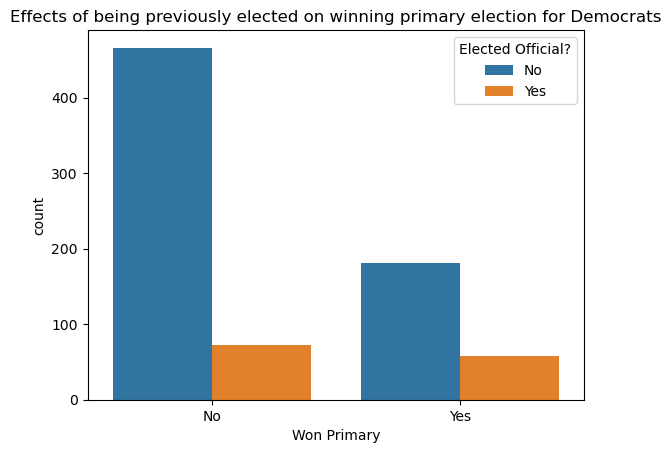

In [8]:
#relationship between Elected Official? and Won Primary 
sns.countplot(data = dem, x = 'Won Primary', hue = 'Elected Official?')
plt.title('Effects of being previously elected on winning primary election for Democrats')

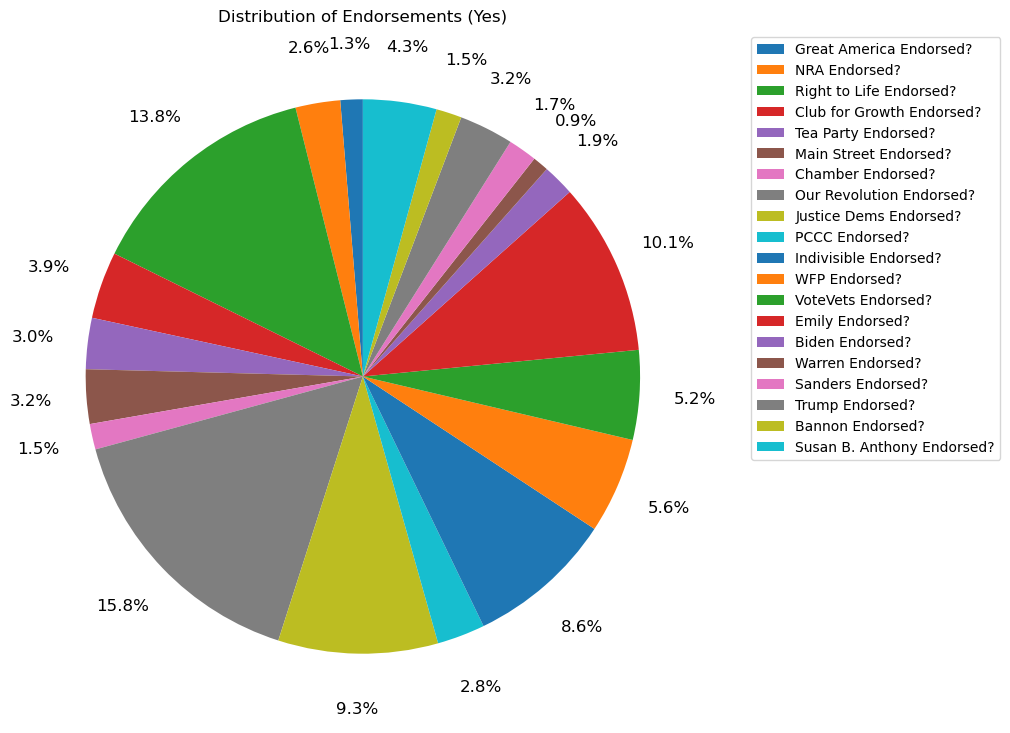

In [9]:
endorsement_columns = [
    "Great America Endorsed?", "NRA Endorsed?", "Right to Life Endorsed?", 
    "Club for Growth Endorsed?", "Tea Party Endorsed?", "Main Street Endorsed?", 
    "Chamber Endorsed?", "Our Revolution Endorsed?", "Justice Dems Endorsed?", 
    "PCCC Endorsed?", "Indivisible Endorsed?", "WFP Endorsed?", 
    "VoteVets Endorsed?", "Emily Endorsed?", "Biden Endorsed?", 
    "Warren Endorsed? ", "Sanders Endorsed?", "Trump Endorsed?", 
    "Bannon Endorsed?", "Susan B. Anthony Endorsed?"
]

endorsement_counts = all_parties[endorsement_columns].apply(lambda col: col.str.count("Yes").sum())
endorsement_counts = endorsement_counts[endorsement_counts > 0]
plt.figure(figsize=(15,9))
plt.pie(endorsement_counts, pctdistance=1.2, autopct='%1.1f%%', startangle=90, textprops={'fontsize':12}, labeldistance=0.1)
plt.legend(endorsement_columns, bbox_to_anchor=(1.05,1), loc='upper left')
plt.title("Distribution of Endorsements (Yes)")
plt.show()



• Visualize at least two quantitative variables and two categorical variables. Your visualizations must be relevant to your research questions!

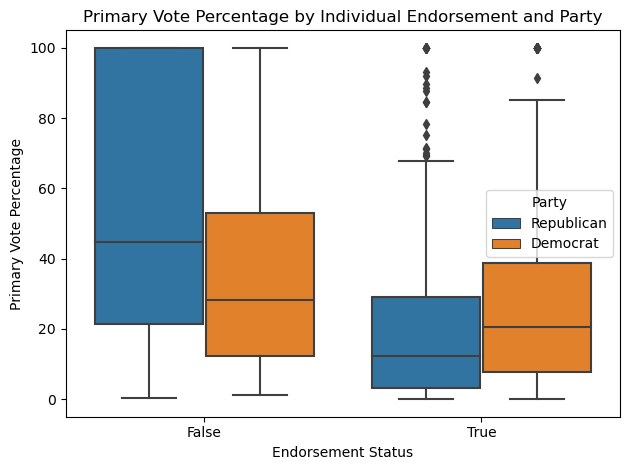

In [10]:
# Republican vs Democrat differences in Primary % with or without endorsement(categorial)

sns.boxplot(
    data=all_parties.reset_index(),
    x='Endorsement',
    y='Primary %',
    hue='Party'
)

plt.title("Primary Vote Percentage by Individual Endorsement and Party")
plt.xlabel("Endorsement Status")
plt.ylabel("Primary Vote Percentage")
plt.legend(title="Party")
plt.tight_layout()
plt.show()

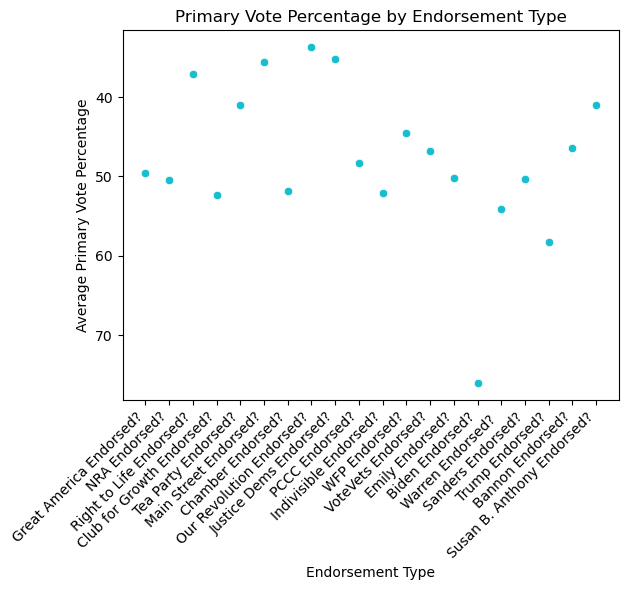

In [11]:
# scatter plot for each endorsement type (quantitative)

endorsement_types = ['Great America Endorsed?', 'NRA Endorsed?', 'Right to Life Endorsed?',
        'Club for Growth Endorsed?', 'Tea Party Endorsed?',
       'Main Street Endorsed?', 'Chamber Endorsed?', 
       'Our Revolution Endorsed?', 'Justice Dems Endorsed?', 'PCCC Endorsed?',
       'Indivisible Endorsed?', 'WFP Endorsed?', 'VoteVets Endorsed?', 'Emily Endorsed?', 'Biden Endorsed?', 'Warren Endorsed? ', 'Sanders Endorsed?', 
    'Trump Endorsed?', 'Bannon Endorsed?', 'Susan B. Anthony Endorsed?']
all_endorsements = pd.DataFrame()
all_primary_percentage = pd.DataFrame()
all_primary_percentage['Endorsement Type'] = endorsement_types
all_primary_percentage['Primary %'] = None

for endorsement_type in endorsement_types:
    endorsement_mean = all_parties.groupby(endorsement_type)['Primary %'].mean().reset_index()['Primary %'][1]
    all_primary_percentage.loc[all_primary_percentage['Endorsement Type'] == endorsement_type, 'Primary %'] = endorsement_mean

    sns.scatterplot(
        data=all_primary_percentage,
        x='Endorsement Type',
        y='Primary %'
    )

plt.title("Primary Vote Percentage by Endorsement Type")
plt.xlabel("Endorsement Type")
plt.ylabel("Average Primary Vote Percentage")
plt.xticks(rotation=45, ha='right')
plt.show()


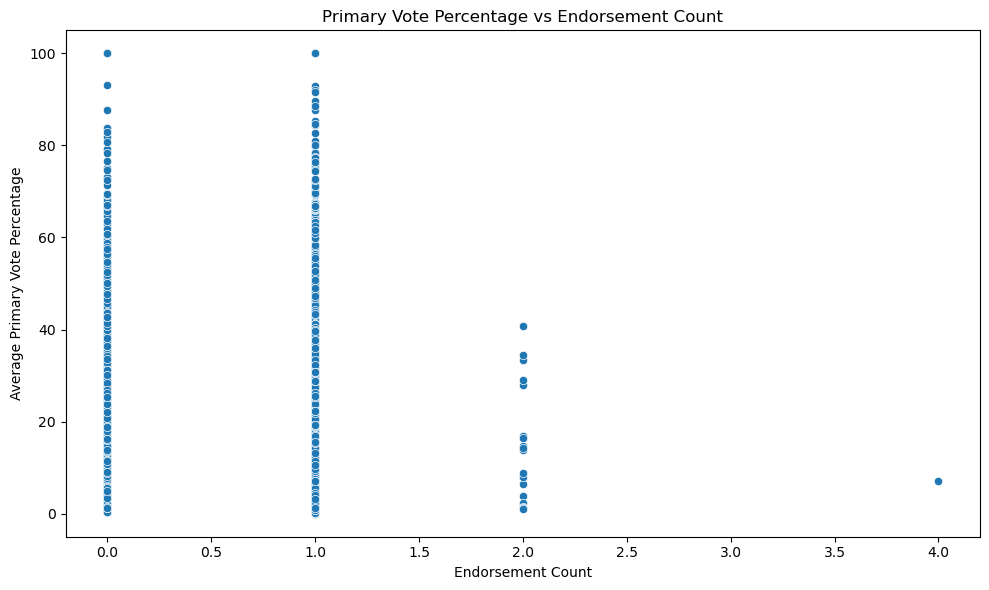

In [12]:
# if higher endorsements cause higher Primary % (quantitative)

endorsement_count_eda['Endorsement Count'] = endorsement_count_eda.groupby('Candidate')['Endorsement'].transform('sum')
average_primary_percentage = endorsement_count_eda.groupby('Candidate')['Primary %'].mean().reset_index()
merged_data = endorsement_count_eda[['Candidate', 'Endorsement Count']].drop_duplicates().merge(average_primary_percentage, on='Candidate')

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=merged_data,
    x='Endorsement Count',
    y='Primary %'
)

plt.title("Primary Vote Percentage vs Endorsement Count")
plt.xlabel("Endorsement Count")
plt.ylabel("Average Primary Vote Percentage")
plt.tight_layout()
plt.show()

• Describe any trends you observe, and any relationships you may want to follow up on.
• Explain how your visualizations should be relevant to your research questions: either by motivating the question, or suggesting a potential answer. You must explain why they are relevant.

- Looking at "Counts of Winning Primary Elections Grouped by Race for Democrats", we observe a stark difference between primary performance between non-white and white candidates in the Democratic Party. We also see that the raw count of non-white candidates is much smaller than white candidates. We shoud take this into consideration when we compare the two categories, and may indicate race may play a big factor in primary winnings. This is relevant to our first causal inference question, and we plan on looking at this coorelation further.
- Looking at "Primary Vote Percentage by Individual Endorsement and Party", the first thing that popped out to us was the high overall distribution of Republicans who didn't get any endorsement at all. We suspect this is because there are a high frequency of smaller elections in smaller towns that vote heavily for a candidate, even if they did not have an endorsement. Making sure to control for this variable, and recognizing this interesting relationship between non-endorsed candidates will be very helpful for any insight to our second question about endorsements and how they impact Primary performance. We also noticed that for people who were endorsed, across both parties, the variance was extremely great. You can see that it was almost a "hit or miss" situation, with a select few dominating the Primary % and most others sinking closer to the bottom, even lower than those who did not recieve any endorsement at all for both parties. Exploring this effect further we believe will also help us bring a better answer to our second question of our final project.
- Looking at "Primary Vote Percentage by Endorsement Type", one thing that we noticed is that for those who got a general endorsement, all of their Primary % was above 35% at worst. This is very interesting as compared to those who didn't recieve an endorsement, most of these candidates who received an endorsement fared the best. We would like to further explore the relationship between endorsements and Primary performance, specifically if there are any major secondary variables like party affiliation can be controlled for. This is very relevant to our second question about perfomance in the primaries and how endorsements can affect your percentages, and we believe this is suggesting that an endorsement from these parties/groups/individuals is much better.
- Looking at "Primary Vote Percentage vs Endorsement Count", we see that most candidates mostly get none or 1 endorsement for their campaign. We also noticed that the primary vote percentage actually went down gradually, but those who were offered one endorsement actually performed the best. Looking at specific endorsements further and seeing how they interact with each other, especially different endorsements, would be very interesting for our second question about exploring the relationship between endorsements and Primary %.

In [13]:
# question 2 data cleaning

data = all_parties[endorsement_columns + ['Primary %']]
data.loc[:, endorsement_columns]= data[endorsement_columns].fillna('No').replace({'No': 0, 'Yes': 1})
for col in endorsement_columns:
    data[col] = pd.to_numeric(data[col])
data = data.dropna(subset=['Primary %'])
data.head(5)

/tmp/ipykernel_786/621866634.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = pd.to_numeric(data[col])


,Great America Endorsed?,NRA Endorsed?,Right to Life Endorsed?,Club for Growth Endorsed?,Tea Party Endorsed?,Main Street Endorsed?,Chamber Endorsed?,Our Revolution Endorsed?,Justice Dems Endorsed?,PCCC Endorsed?,...,WFP Endorsed?,VoteVets Endorsed?,Emily Endorsed?,Biden Endorsed?,Warren Endorsed?,Sanders Endorsed?,Trump Endorsed?,Bannon Endorsed?,Susan B. Anthony Endorsed?,Primary %
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,61.8
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,31.9
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.6
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.3


In [14]:
# question 2 Train-Test Split
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=101)

In [15]:
# question 2 GLM Model

model = sm.GLM(train['Primary %'], exog=sm.add_constant(train[endorsement_columns]), family=sm.families.Gaussian())
results = model.fit()

train["glm_pred"] = results.predict(sm.add_constant(train[endorsement_columns]))
test["glm_pred"] = results.predict(sm.add_constant(test[endorsement_columns]))

print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Primary %   No. Observations:                 1101
Model:                            GLM   Df Residuals:                     1080
Model Family:                Gaussian   Df Model:                           20
Link Function:               Identity   Scale:                          844.09
Method:                          IRLS   Log-Likelihood:                -5261.1
Date:                Fri, 06 Dec 2024   Deviance:                   9.1162e+05
Time:                        01:56:03   Pearson chi2:                 9.12e+05
No. Iterations:                     3   Pseudo R-squ. (CS):            0.06192
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [20]:
# question 2 GLM Model Metrics
glm_train_rmse = np.mean((train["glm_pred"] - train["Primary %"]) ** 2) ** 0.5
glm_test_rmse = np.mean((test["glm_pred"] - test["Primary %"]) ** 2) ** 0.5

glm_train_r2 = metrics.r2_score(train['Primary %'], train["glm_pred"])
glm_test_r2 = metrics.r2_score(test['Primary %'], test["glm_pred"])

print(f"GLM Training RMSE: {glm_train_rmse:.4f}")
print(f"GLM Test RMSE:     {glm_test_rmse:.4f}")
print(f"GLM Training R²:   {glm_train_r2:.4f}")
print(f"GLM Test R²:       {glm_test_r2:.4f}")
print(f"AIC for the GLM:   {results.aic:.4f}")

GLM Training RMSE: 28.7748
GLM Test RMSE:     27.6585
GLM Training R²:   0.0610
GLM Test R²:       0.0622
AIC for the GLM:   10564.1254


In [21]:
# question 2 Decision Tree Model
from sklearn.tree import DecisionTreeRegressor

tree_model = DecisionTreeRegressor()
tree_model.fit(train[endorsement_columns], train['Primary %'])

train["tree_pred"] = tree_model.predict(train[endorsement_columns])
test["tree_pred"] = tree_model.predict(test[endorsement_columns])

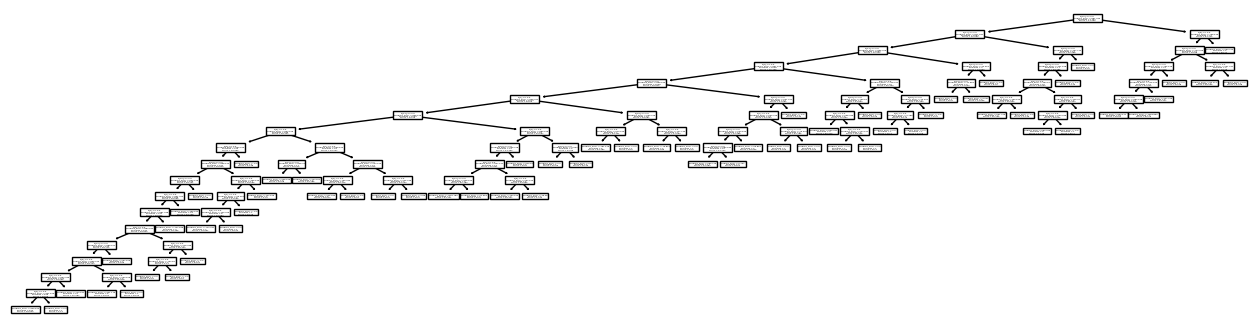

In [22]:
# question 2 Decision Tree Plot
from sklearn.tree import plot_tree

plt.figure(figsize=(16, 4))
plot_tree(tree_model);

In [26]:
# question 2 decision tree rmse
tree_train_rmse = np.mean((train["tree_pred"] - train["Primary %"]) ** 2) ** 0.5
tree_test_rmse = np.mean((test["tree_pred"] - test["Primary %"]) ** 2) ** 0.5

tree_train_r2 = metrics.r2_score(train['Primary %'], train['tree_pred'])
tree_test_r2 = metrics.r2_score(test['Primary %'], test['tree_pred'])

tree_train_rss = np.sum((train["Primary %"] - train['tree_pred']) ** 2)
tree_train_aic = 2 * tree_model.get_n_leaves() + len(train) * np.log(tree_train_rss / len(train))

print(f"Decision Tree Training RMSE: {tree_train_rmse:.4f}")
print(f"Decision Tree Test RMSE:     {tree_test_rmse:.4f}")
print(f"Decision Tree Training R²:   {tree_train_r2:.4f}")
print(f"Decision Tree Test R²:       {tree_test_r2:.4f}")
print(f"AIC for the GLM:             {tree_train_aic:.4f}")

Decision Tree Training RMSE: 28.4070
Decision Tree Test RMSE:     28.2315
Decision Tree Training R²:   0.0849
Decision Tree Test R²:       0.0230
AIC for the GLM:             7497.2893
